## HW02 Code

### Name: Yunke Zhu

You will complete the following notebook, as described in the PDF for Homework 02 (included in the download with the starter code).  You will submit:
1. This notebook file, along with your COLLABORATORS.txt file, to the Gradescope link for code.
2. A PDF of this notebook and all of its output, once it is completed, to the Gradescope link for the PDF.  (This can be generated by printing the notebook as PDF, or using the **File -> Download as** menu.)


Please report any questions to the [class Piazza page](https://piazza.com/tufts/spring2020/comp135/home).

In [77]:
# import libraries as needed
import numpy as np
import pandas as pd
import math
import operator

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression




from matplotlib import pyplot as plt
import seaborn as sns
np.set_printoptions(suppress=True, precision=2)
%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

### Plotting function

**Do not modify the following**: it takes in a list of polynomial (integer) values, along with associated lists consisting of the predictions made for the associated model, and the resulting error, and plots the results in a grid.

In [78]:
def plot_predictions(polynomials=list(), prediction_list=list(), error_list=list()):
    '''Plot predicted results for a number of polynomial regression models
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model.
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    
        Note: it is expected that all lists are of the same length, and 
            that this length be some perfect square (for grid-plotting).
    '''
    length = len(prediction_list)
    grid_size = int(math.sqrt(length))
    if not (length == len(polynomials) and length == len(error_list)):
        raise ValueError("Input lists must be of same length")
    if not length == (grid_size * grid_size):
        raise ValueError("Need a square number of list items (%d given)" % (length))
    fig, axs = plt.subplots(grid_size, grid_size, figsize =(14,14), sharey=True)
    for subplot_id, prediction in enumerate(prediction_list):
        # order data for display
        data_frame = pd.DataFrame(data=[x[:, 0], prediction]).T
        data_frame = data_frame.sort_values(by=0)
        x_sorted = data_frame.iloc[:, :-1].values
        prediction_sorted = data_frame.iloc[:, 1].values

        ax = axs.flat[subplot_id]
        ax.set_title('degree = %d; MSE = %.3f' % (polynomials[subplot_id], error_list[subplot_id]))
        ax.plot(x, y, 'r.')
        ax.plot(x_sorted, prediction_sorted, color='blue')
        
    plt.show()

### Load the dataset

In [79]:
data = pd.read_csv('data.csv')
data

,x_i,y_i
0,1.590909,2.846988
1,1.803030,2.959811
2,4.984848,13.041394
3,1.696970,3.971889
4,1.272727,2.454520
...,...,...
95,5.090909,11.537465
96,10.500000,10.381492
97,1.484848,2.683212
98,0.636364,1.437600


In [80]:
x = data.iloc[:, :-1].values
y = data.iloc[:, 1].values

### 1. Test a range of polynomial functions fit to the data

Fit models to data of polynomial degree $d \in \{1, 2, 3, 4, 5, 6, 10, 11, 12\}$.  For each such model, we will record its predictions on the input data, along with the mean squared error (MSE) that it makes.  These results are then plotted for comparison.

#### 1.1 Create function to generate models, make predictions, measure error.

In [81]:
def test_polynomials(polynomials=list(),x=x, y=y):
    '''Generates a series of polynomial regression models on input data.
       Each model is fit to the data, then used to predict values of that
       input data.  Predictions and mean squared error are collected and
       returned as two lists.
    
    Args
    ----
    polynomials : list of positive integer values
        Each value is the degree of a polynomial regression model, to be built.
    
    Returns
    -------
    prediction_list: list of arrays ((# polynomial models) x (# input data))
        Each array contains the predicted y-values for input data.
    error_list: list of error values ((# polynomial models) x 1)
        Each value is the mean squared error (MSE) of the model with 
        the associated polynomial degree.
    '''
    prediction_list = list()
    error_list = list()
    for degree in polynomials:
        poly = PolynomialFeatures(degree)
        xTrain = poly.fit_transform(x)
        LinearRegressionPoly = LinearRegression()
        LinearRegressionPoly.fit(xTrain, y)
        yTrainPredict = LinearRegressionPoly.predict(xTrain)
        prediction_list.append(yTrainPredict)
        #print (y,yTrainPredict) / max(y)
        error_list.append( mean_squared_error(y, yTrainPredict))        
        

    # TODO: fill in this function to generate the required set of models,
    #       returning the predictions and the errors for each.
        
    return prediction_list, error_list
    

In [82]:
# TODO: generate the sequence of degrees, call test_polynomials to create models,
#       use plot_predictions to show the results

In [83]:
prediction_list, error_list = test_polynomials([1,2,3,4,5,6,10,11,12],x,y)

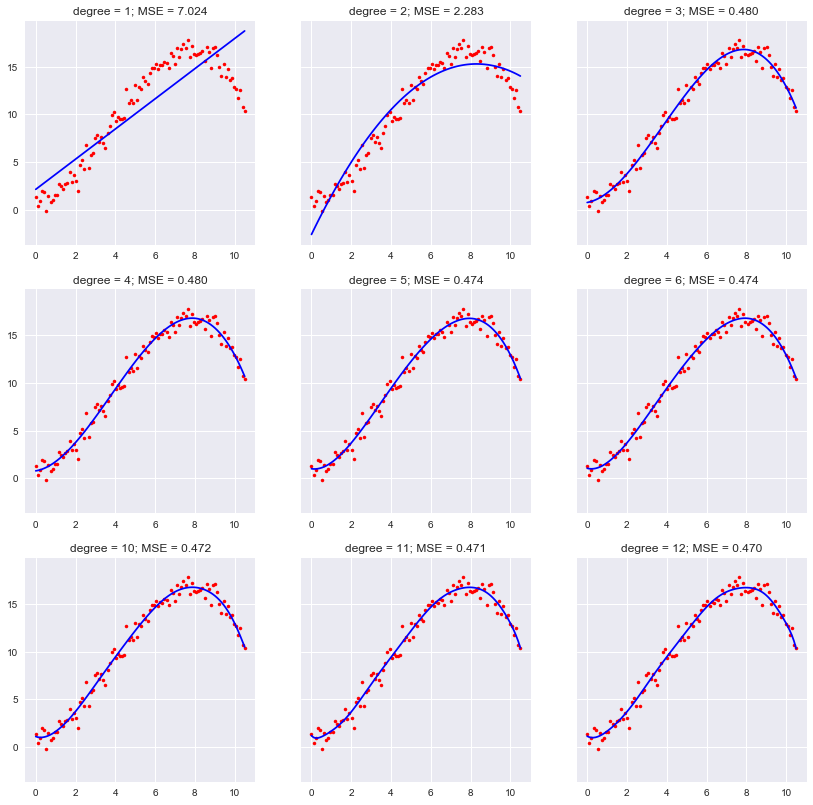

In [84]:
plot_predictions([1,2,3,4,5,6,10,11,12], prediction_list, error_list)

#### 1.2 Discuss the results seen in the plots above

**Discussion**: From the given 9 degrees, the degree of 12 is the best model. From these models we can say that the MSE for the trainning data set becomes smaller as degree goes up. The one dimension linear model is the worst model with largest MSE. But all these features are shown for the trinning data set.\
Actually, this model adjust its weight via gradient discent, so as degree grows, the training error will be smaller. Suppose we have n data for our training, then as the degree reaches n, the training error will become 0. However, this only works for training data set while will fail to minimize testing data because of overfitting problem, we will discuss this later.

### 2. $k$-fold cross-validation 

For each of the polynomial degrees, 5-fold cross-validation is performed.  Data is divided into 5 equal parts, and 5 separate models are trained and tested.  Results are averaged over the 5 runs and plotted (in a single plot), comparing training and test error for each of the polynomial degrees.  Error values are also shown in a tabular form.

#### 2.1 Creating the $k$ folds

A function that generates the distinct, non-overlapping folds of the data.

In [85]:
def make_folds(num_folds=1,x=None, y=None):
    '''Splits data into num_folds separate folds for cross-validation.
       Each fold should consist of M consecutive items from the
       original data; each fold should be the same size (we will assume 
       that  the data divides evenly by num_folds).  Every data item should 
       appear in exactly one fold.
       
       Args
       ----
       num_folds : some positive integer value
           Number of folds to divide data into.
           
        Returns
        -------
        x_folds : list of sub-sequences of original x-data 
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
        y_folds : list of sub-sequences of original y data
            There will be num_folds such sequences; each will 
            consist of 1/num_folds of the original data, in
            the original order.
       '''
    i = 0
    step = int(len(x) / num_folds)
    x_folds = list()
    y_folds = list()
    for k in range(num_folds):
        x_folds.append(x[i:i+step])
        y_folds.append(y[i:i+step])
        i += step
    
    # TODO: Complete method to generate partition into folds.
    
    return x_folds, y_folds

In [86]:
# Print out start/end of each fold for sanity check.  Should see 5 folds,
# with the (x,y) pairs at the start/end of each.  (Can be manually verified 
# by looking at original input file.)
#
# DO NOT MODIFY THIS CODE.  Its output will be used to check your work.
k = 5
x_folds, y_folds = make_folds(k,x,y)
for i in range(k):
    print("Fold %d: (%.3f, %.3f) ... (%.3f, %.3f)"
         % (i, x_folds[i][0], y_folds[i][0], x_folds[i][-1], y_folds[i][-1]))

Fold 0: (1.591, 2.847) ... (10.394, 10.739)
Fold 1: (6.788, 16.408) ... (2.227, 4.722)
Fold 2: (9.545, 13.897) ... (3.924, 10.229)
Fold 3: (2.864, 5.929) ... (7.212, 16.030)
Fold 4: (7.530, 16.982) ... (0.848, 0.990)


#### 2.2 Perform cross-validation

For each of the polynomial degrees already considered, $k$-fold cross-validation is performed.  Average training error (MSE) and test error (MSE) are reported, both in the form of a plot and a tabular print of the values.

In [87]:
# TODO: Perform 5-fold cross-validation for each polynomial degree.  
#       Keep track of average training/test error for each degree; 
#       Plot results in a single table, properly labeled, and also
#       print out the results in some clear tabular format.

In [88]:
def generateFolds(k=1):
    xTrains=[]
    yTrains=[]
    step = int(len(x) / k)
    j = 0
    for i in range(k):
        rows = [_ for _ in range(j,j+step)]
        xTrains.append(np.delete(x,rows,0))
        yTrains.append(np.delete(y,rows,0))
        j += step
    return xTrains,yTrains


In [89]:
def TestingTrainingError(xTrains=None,yTrains=None,polyFeatures=[1]):
    
    testErrors = []
    trainErrors = []
    for degree in polyFeatures:
        testError = 0
        trainError = 0
        for i in range(k):
            xTrain = tuple(xTrains[i])
            yTrain = tuple(yTrains[i])
            xTest = tuple(x_folds[i])
            yTest = tuple(y_folds[i])
            sorted_zip = sorted(zip(xTrain, yTrain), key=operator.itemgetter(0))
            xTrain, yTrain = zip(*sorted_zip)
            poly = PolynomialFeatures(degree)
            xTrainPoly = poly.fit_transform(xTrain)
            xTestPoly = poly.fit_transform(xTest)
            linearRegressionPoly = LinearRegression()
            linearRegressionPoly.fit(xTrainPoly, yTrain)
            yTestPredict = linearRegressionPoly.predict(xTestPoly)
            yTrainPredict = linearRegressionPoly.predict(xTrainPoly)
            testError += mean_squared_error(yTest, yTestPredict)
            trainError += mean_squared_error(yTrain,yTrainPredict)
        testErrors.append(testError / k)
        trainErrors.append(trainError / k)
    return testErrors,trainErrors


In [91]:
xTrains,yTrains = generateFolds(k)
polyFeatures = [1,2,3,4,5,6,10,11,12]
testErrors,trainErrors = TestingTrainingError(xTrains,yTrains,polyFeatures)

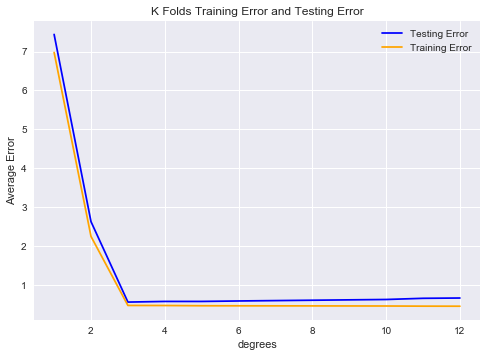

In [93]:
plt.plot(polyFeatures, testErrors, color='blue', label = 'Testing Error')
plt.plot(polyFeatures, trainErrors, color='orange', label = 'Training Error')
plt.title('K Folds Training Error and Testing Error')
plt.xlabel('degrees')
plt.ylabel('Average Error')
plt.legend()
plt.show()

#### 2.3 Discuss the results seen in the plots above

**Discussion:** As the degree goes up, we can see that the MSE for training data is getting smaller but the MSE is getting steady as well. \
As for the testing error, the lowest MSE is when degree = 3. After this degree, the MSE grows as rapidly as degree's value. The reason that testing error unlike training error is due to the overfitting problem. Although the current line for testing error seems plain, but it will grows very rapidly after the degree getting higher value.\
The basic reason of this overfitting problem occurs is our original data is one dimension but we fit it with higher degree which will cause a overfitting problem. 

### 3. Higher-order polynomials

Results are generated and plotted (as for part 1), for the higher polynomial degrees $d = \{15, 17, 19, 21, 25, 30, 35, 40, 50\}$.

#### 3.1 Plot a grid of prediction results/errors for the higher-order polynomials

In [94]:
# TODO: generate and plot 9 more models, for the higher-degree polynomials indicated.

In [95]:
d = [15,17,19,21,25,30,35,40,50]
testErrors,trainErrors = TestingTrainingError(xTrains,yTrains,d)

In [96]:
prediction_list, error_list = test_polynomials(d,x,y)


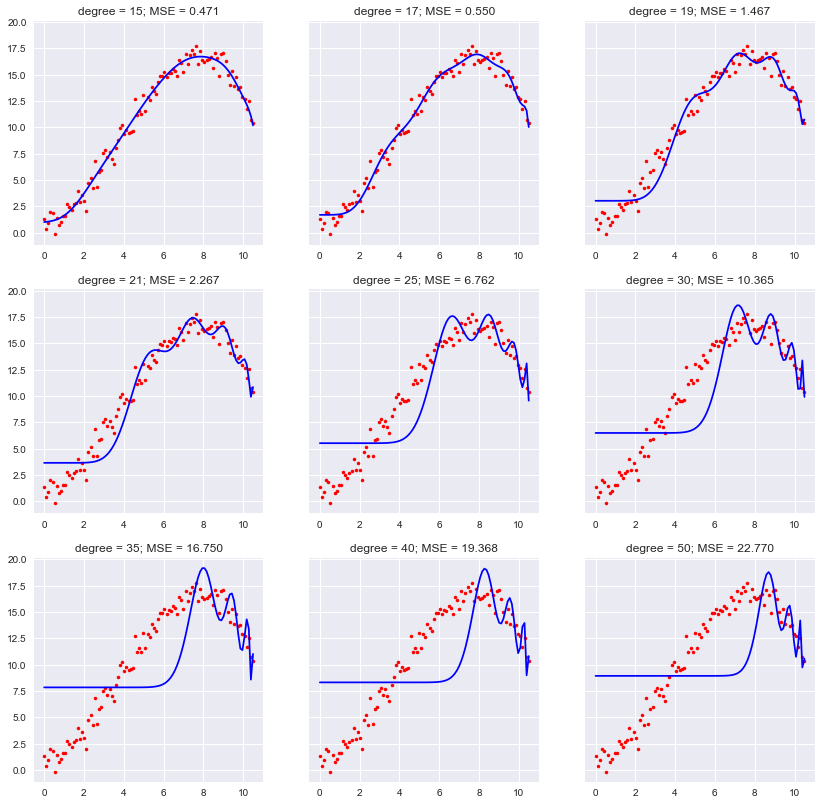

In [97]:
plot_predictions(d, prediction_list, error_list)

#### 3.2 Discuss the results seen in the plots above

**Discussion**: Undoubtedly, as degree grows, the overfitting problem will be much apparent, and the MSE will be larger. But an interesting thing is to find out why the start of the line is a plain line. Basically, as the degree goes up and our linear regression model is always tring to find out the minimum MSE. But compared to different data sets, it is apparent that $x^{50}$ will lead much more influence than $x^2$ will lead when computing MSE. So the final weight will adjust itself to the value that will cause less impact for higher x value. Let's list an example as follows:\
Suppose the final model is $y=w_0+w_1x+w_2x^2+...+w_{50}x^{50}$, then we apply the value of each x, let's say x=0.1,1,3,10,100... And firstly we can easily know that the higher degree dominates the value of y. And the difference of y bewtween x=99 and x=100 is much larger than the difference of y when x=1 and x = 2. And since linear regression model is trying to minimum MSE, the value of smaller value of x will have less impact. And this is the reason that the line is plain at first part because the model is focus on the latter x with larger values. As degree goes up, we can see that the model is getting squeezed since it will put more emphsis on the larger value of x, which will cause larger MSE.

### 4. Regularized (ridge) regression

Ridge regularization is a process whereby the loss function that is minimized combines the usual measure (error on the training data) with a penalty that is applied to the magnitude of individual coefficients.  This latter penalty discourages models that overly emphasize any single feature, and can often prevent over-fitting.

Here, a set of 50 different `sklearn.linear_model.Ridge` models are generated, each using a single polynomial degree (the one that was determined to be best for the data-set in earlier tests), and using a range of different regularization penalties, chosen from a logarithmic series: $s \in [0.01, 100]$.  5-fold cross-validation is again used to examine how robust these models are.

#### 4.1 Cross-validation for each regularization strength value

In [98]:
# TODO: Generate a sequence of 50 ridge models, varying the regularization strength
#       from 0.01 (10^-2) to 100 (10^2).  Each model is 5-fold cross-validated and
#       the resulting average training/test errors are tracked.  Errors are then
#       plotted (on a logarithmic scale) and printed in some legible tabular form.

In [99]:
from sklearn.linear_model import Ridge
xTrains,yTrains = generateFolds(k)

In [102]:
def generateRidge(xTrains=None,yTrains=None,degree=1,regularization=None):
    testErrors = []
    trainErrors = []
    for alpha in regularization:
        testError = 0
        trainError = 0
        for i in range(k):
            xTrain = tuple(xTrains[i])
            yTrain = tuple(yTrains[i])
            xTest = tuple(x_folds[i])
            yTest = tuple(y_folds[i])
            sorted_zip = sorted(zip(xTrain, yTrain), key=operator.itemgetter(0))
            xTrain, yTrain = zip(*sorted_zip)
            poly = PolynomialFeatures(degree)
            xTrainPoly = poly.fit_transform(xTrain)
            xTestPoly = poly.fit_transform(xTest)
            ridgeRegressionPoly = Ridge(alpha)
            ridgeRegressionPoly.fit(xTrainPoly,yTrain)
            yTestPredict = ridgeRegressionPoly.predict(xTestPoly)
            yTrainPredict = ridgeRegressionPoly.predict(xTrainPoly)
            testError += mean_squared_error(yTest, yTestPredict)
            trainError += mean_squared_error(yTrain,yTrainPredict)
        testErrors.append(testError / k)
        trainErrors.append(trainError / k)
    return testErrors,trainErrors

In [103]:
degree = 3
regularization = np.logspace(-2, 2, base=10, num=50)
testErrors,trainErrors = generateRidge(xTrains,yTrains,degree,regularization)


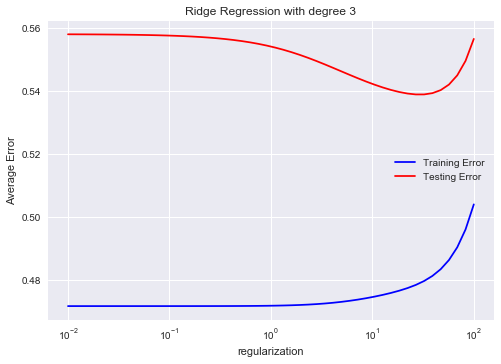

In [104]:
import matplotlib
plt.xscale('log')
#plt.scatter(testErrors, regularization, color='red')
plt.plot(regularization,trainErrors, color='blue',label = "Training Error")
plt.plot(regularization,testErrors, color='red', label = "Testing Error")
plt.title('Ridge Regression with degree ' + str(degree))
plt.xlabel('regularization')
plt.ylabel('Average Error')
plt.legend()
plt.show()

#### 4.2 Discuss the results seen in the plots above

**Discussion**:  The optimal degree from above model is when degree is 3, so we will use degree with 3 to apply for our ridge regression.\
Ridge regression, compared to the original linear regression, its loss function is added by a regularization part with $\alpha$. The $\alpha$ stands for the weight of the regularization is. If the $\alpha$ is very large, which means our additional regularization will cause more influence on the loss function, and suppose $\alpha$ is much much larger than the original part, which will cause the weight to 0, this is meaningless. But if $\alpha$ is too small, suppose $\alpha$ equals to 0, then our regularization part is useless. So we are trying to find out the most optimal value of $\alpha$ which can help us get the minimum MSE. As for this graph above, the optimal $\alpha$ is around 30. 